In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from env import PredatorPreyTask

/Users/felixgaschi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class CommNetPP:
    
    def __init__(self, sess, N, grid_size, embedding_size = 50, lr = 1e-3, alpha = 0.03, lstm_controler = False):
        
        self.N = N
        self.embedding_size = embedding_size
        self.n_actions = 6 # Stay, North, South, East, West, Communicate
        self.grid_size = grid_size
        
        if lstm_controler:
            self.build_lstm_controler()
        else:
            self.build_controler()
        
        
        self.alpha = 0.03
        self.build_reinforce()
        with tf.variable_scope('Reinforce_optimizer'):
            self.train_op =  tf.train.RMSPropOptimizer(lr).minimize(self.reinforce_loss)
            
        
        print("All variables")
        for var in tf.global_variables():
            print(var)
            
        
        self.sess = sess
        self.sess.run(tf.global_variables_initializer())
        
    def encode(self, inputs):
        
        agent_positions = inputs[0]
        prey_positions = inputs[1]
        
        print(agent_positions)
        print(prey_positions)
        
        with tf.variable_scope('Encoder'):
        
            self.agent_position_embedding = tf.get_variable("agent_position_embedding",
                                             [self.grid_size**2 + 1, self.embedding_size]) # 0 not used
            
            self.embedded_agent_position = tf.nn.embedding_lookup(self.agent_position_embedding, agent_positions)
            
            
            
            
            self.prey_position_embedding = tf.get_variable("prey_position_embedding",
                                             [self.grid_size**2 + 1, self.embedding_size]) # 0 --> cannot see the prey
            
            self.embedded_prey_position = tf.nn.embedding_lookup(self.prey_position_embedding, prey_positions)
        
        
        print(self.embedded_prey_position)
        h0 = tf.concat([self.embedded_agent_position, self.embedded_prey_position], axis = 2)
        h0_seq = tf.unstack(h0, axis = 1)
        
        return h0_seq
    
    def build_f(self, name, h, c, h0 = None):
        
        with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
            
            if h0 is not None and c is not None:
            
                b1 = tf.get_variable('b1', shape = (1, 2 * self.embedding_size))
                W1 = tf.get_variable('W1', shape = (3 * 2 * self.embedding_size,
                                                  2 * self.embedding_size))
                
                W2 = tf.get_variable('W2', shape = (2 * self.embedding_size,
                                                  2 * self.embedding_size))
                
                concat = tf.concat([h, c, h0], axis = 1)
            
            elif h0 is not None and c is None: 
                b1 = tf.get_variable('b1', shape = (1, 2* self.embedding_size))
                
                W1 = tf.get_variable('W1', shape = (2 * 2 * self.embedding_size,
                                                  2 * self.embedding_size))
                
                W2 = tf.get_variable('W2', shape = (2 * self.embedding_size,
                                                  2 * self.embedding_size))
                
                concat = tf.concat([h, h0], axis = 1)
                
            elif c is not None and h0 is None:
                
                b1 = tf.get_variable('b1', shape = (1, 2 * self.embedding_size))
                
                W1 = tf.get_variable('W1', shape = (2 * 2 *self.embedding_size,
                                                  2 * self.embedding_size))
                
                W2 = tf.get_variable('W2', shape = (2 * self.embedding_size,
                                                  2 * self.embedding_size))
                
                concat = tf.concat([h, c], axis = 1)
                
            else:
                
                b1 = tf.get_variable('b1', shape = (1, 2 *self.embedding_size))
                
                W1 = tf.get_variable('W1', shape = (2 * self.embedding_size,
                                                  2 * self.embedding_size))
                
                W2 = tf.get_variable('W2', shape = (2 * self.embedding_size,
                                                  2 * self.embedding_size))
                
                concat = h
                
                
            b2 = tf.get_variable('b2', shape = (1, 2 * self.embedding_size))
            
            dense1 =tf.nn.relu(tf.einsum("ij,jk->ik", concat, W1) + b1)
            dense2 = tf.nn.relu(tf.einsum("ij,jk->ik", dense1, W2) + b2)
            
            return dense2
        
    def decode_movement(self, h):
        
        with tf.variable_scope('Decoder_movement', reuse = tf.AUTO_REUSE):
            
            W = tf.get_variable('W', shape = (2 * self.embedding_size,
                                                  self.n_actions - 1))
            
            b = tf.get_variable('b', shape = (1, self.n_actions - 1))
            
            policy_logit = tf.einsum("ij,jk->ik", h, W) + b
        
            return policy_logit
        
    def decode_communication(self, h):
        
        with tf.variable_scope('Decoder_communication', reuse = tf.AUTO_REUSE):
            
            W = tf.get_variable('W', shape = (2 * self.embedding_size,
                                                  2))
            
            b = tf.get_variable('b', shape = (1, 2))
            
            policy_logit = tf.einsum("ij,jk->ik", h, W) + b
        
            return policy_logit
        
    def communicate(self, h_seq):
        
        return tf.add_n(h_seq) / (self.N - 1)
    
    def sample_actions(self, log_proba):
        
        action = tf.multinomial(log_proba, num_samples = 1)
        
        return action
    
        
    def build_controler(self):
        
        self.inputs = tf.placeholder(tf.int32, shape = (None, 2, self.N))
        
        h0_seq = self.encode(tf.unstack(self.inputs, axis = 1))
        
        print(h0_seq)
        
        c0_seq = [self.communicate([h0_seq[j] for j in range(self.N) if j != i]) for i in range(self.N)]
        
        h1_seq = [self.build_f("Comm_step_1", h0_seq[j], c0_seq[j], None) for j in range(self.N)]
        c1_seq = [self.communicate([h1_seq[j] for j in range(self.N) if j != i]) for i in range(self.N)]
        
        self.h2_seq = [self.build_f("Comm_step_2", h1_seq[j], c1_seq[j], h0_seq[j]) for j in range(self.N)]
        
        self.layers = {'h0_seq': h0_seq, 'h1_seq': h1_seq, 'c1_seq':c1_seq, 'h2_seq': self.h2_seq}
        
        
        self.movement_policy_logit_seq = [self.decode_movement(h2) for h2 in self.h2_seq]
        self.communication_policy_logit_seq = [self.decode_communication(h2) for h2 in self.h2_seq]
        
        self.movement_log_proba_seq = [tf.nn.log_softmax(policy_logit, axis = 1) for policy_logit in self.movement_policy_logit_seq]
        self.communication_log_proba_seq = [tf.nn.log_softmax(policy_logit, axis = 1) for policy_logit in self.communication_policy_logit_seq]
        
        self.movement_action_seq = [self.sample_actions(log_proba) for log_proba in self.movement_log_proba_seq]
        self.communication_action_seq = [self.sample_actions(log_proba) for log_proba in self.communication_log_proba_seq]
        
        print(self.movement_action_seq)
        print(self.movement_action_seq)
        
    def build_lstm(self, name, cell_state):
        
        with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
            
            lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(2 * 2 * self.embedding_size)
            concat = tf.concat([h, c, h0], axis = 1)
            
            tf.nn.dynamic_rnn(inputs = concat, cell = lstm_cell, initial_state = cell_state)
            
            #TODO --> gérer le state du RNN
    
    def build_lstm_controler(self):
        
        self.inputs = tf.placeholder(tf.int32, shape = (None, 2, self.N))
        
        h_seq = self.encode(tf.unstack(self.inputs, axis = 1))
        
        print(h_seq)
        
        c_seq = [self.communicate([h_seq[j] for j in range(self.N) if j != i]) for i in range(self.N)]
        
        h_seq = [self.build_lstm("Comm_step_lstm", h0_seq[j], c_seq[j]) for j in range(self.N)]
                
        
        self.movement_policy_logit_seq = [self.decode_movement(h) for h in self.h_seq]
        self.communication_policy_logit_seq = [self.decode_communication(h) for h in self.h_seq]
        
        self.movement_log_proba_seq = [tf.nn.log_softmax(policy_logit, axis = 1) for policy_logit in self.movement_policy_logit_seq]
        self.communication_log_proba_seq = [tf.nn.log_softmax(policy_logit, axis = 1) for policy_logit in self.communication_policy_logit_seq]
        
        self.movement_action_seq = [self.sample_actions(log_proba) for log_proba in self.movement_log_proba_seq]
        self.communication_action_seq = [self.sample_actions(log_proba) for log_proba in self.communication_log_proba_seq]
        
        print(self.movement_action_seq)
        print(self.movement_action_seq)        
        
            
    def build_baseline(self, h):
        
        with tf.variable_scope('Baseline', reuse = tf.AUTO_REUSE):
            
            W = tf.get_variable('W', shape = (2 * self.embedding_size,
                                                  1))
            
            b = tf.get_variable('b', shape = (1,))
            
            
            baseline = tf.einsum("ij,jk->ik", h, W) + b
            
            return baseline
            

    def build_reinforce(self):
        
        
        self.baselines = tf.concat([self.build_baseline(h2) for h2 in self.h2_seq], axis = 1)
                    
        self.reward_values = tf.placeholder(tf.float32, shape = (None, self.N))
        self.reward_values_cumsum = tf.cumsum(self.reward_values, axis = 0, reverse = True)
        
        self.baseline_values =  tf.placeholder(tf.float32, shape = (None, self.N))
               
        
        self.movement_action_taken = tf.placeholder(tf.int32, shape = (None, self.N))
        unstacked_movement_action_taken = tf.unstack(self.movement_action_taken, axis = 1)
        
        self.communication_action_taken = tf.placeholder(tf.int32, shape = (None, self.N))
        unstacked_communication_action_taken = tf.unstack(self.communication_action_taken, axis = 1)
        
        self.movement_neg_log_p = tf.transpose(tf.concat([[tf.nn.sparse_softmax_cross_entropy_with_logits(labels=unstacked_movement_action_taken[j],
                                                    logits=self.movement_policy_logit_seq[j])] for j in range(self.N)], axis = 0))
        
        self.communication_action_taken = tf.placeholder(tf.int32, shape = (None, self.N))
        unstacked_communication_action_taken = tf.unstack(self.communication_action_taken, axis = 1)
        
        self.communication_neg_log_p = tf.transpose(tf.concat([[tf.nn.sparse_softmax_cross_entropy_with_logits(labels=unstacked_communication_action_taken[j],
                                                    logits=self.communication_policy_logit_seq[j])] for j in range(self.N)], axis = 0))
        
        self.neg_log_p = self.movement_neg_log_p + self.communication_neg_log_p
        #surrogate loss (- dtheta)
        
        self.reinforce_loss = tf.reduce_sum(tf.multiply(self.neg_log_p, self.reward_values_cumsum - self.baseline_values))
        self.reinforce_loss += self.alpha * tf.reduce_sum(tf.square(self.reward_values_cumsum - self.baselines))
        self.reinforce_loss /= self.N
        
        print(self.reinforce_loss)
        
    def take_action(self, state):
        
        
        movement_action_seq, communication_action_seq, baselines= self.sess.run([self.movement_action_seq, self.communication_action_seq, self.baselines], {self.inputs: [state]})
        
        return [a[0,0] for a in movement_action_seq], [a[0,0] for a in communication_action_seq],  baselines
    
    def reinforce_train(self, env, n_episodes, T):
        
        
        history = {'reward' : [],  'loss': []}
        
        for _ in tqdm_notebook(range(n_episodes), "REINFORCE"):
            
            
            state_seq, movement_action_seq, communication_action_seq , reward_seq, baseline_seq = policy_rollout(T, env, self)
            episode_len = reward_seq.shape[0]
            
            history['reward'].append(np.mean(reward_seq))
                
            feed_dict = {}
            feed_dict[self.inputs] = state_seq
            feed_dict[self.reward_values] = reward_seq
            feed_dict[self.baseline_values] = baseline_seq
            feed_dict[self.movement_action_taken] = movement_action_seq
            feed_dict[self.communication_action_taken] = communication_action_seq
            
            _, loss = self.sess.run([self.train_op, self.reinforce_loss], feed_dict = feed_dict)
            
            history['loss'].append(loss)
            
        return history
            
            
            
            
            
            
            
        

In [64]:
# episode generation for reinforcement learning
def policy_rollout(T, env, agent):
    
    state_seq = []
    movement_action_seq = []
    communication_action_seq = []
    reward_seq = []
    baseline_seq = []
    
    
    state, terminal_state = env.reset()
    while terminal_state:
        state, terminal_state = env.reset()
    
    t = 0
    
    while not terminal_state and t < T:
        t +=1
        
        state_seq.append(state)
        movement_action, communication_action, baseline = agent.take_action(state)
        
        state, reward, terminal_state = env.step(movement_action, communication_action)
        
        movement_action_seq.append(movement_action)
        communication_action_seq.append(communication_action)
        reward_seq.append(reward)
        baseline_seq.append(baseline)
    
    
    baseline = np.squeeze(np.array(baseline))
    if len(baseline.shape) == 1:
        baseline = baseline.reshape(1,-1)
    
    return np.array(state_seq), np.array(movement_action_seq), np.array(communication_action_seq),np.array(reward_seq), baseline

In [70]:
N = 4
grid_size = 10

In [71]:
tf.reset_default_graph()
with tf.Session() as sess:
    commNet = CommNetPP(sess, N,  grid_size, lstm_controler = False)
    env = PredatorPreyTask(N = N, grid_size = grid_size, detection_range = 2, prey_detection_range = 2, T=200, forbidden_cost=0.)    
    history = commNet.reinforce_train(env, n_episodes = 1000, T =200)
    
    state_seq, movement_action_seq, communication_action_seq, reward_seq, baseline_seq = policy_rollout(200, env, commNet)

Tensor("unstack:0", shape=(?, 4), dtype=int32)
Tensor("unstack:1", shape=(?, 4), dtype=int32)
Tensor("Encoder/embedding_lookup_1/Identity:0", shape=(?, 4, 50), dtype=float32)
[<tf.Tensor 'unstack_1:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'unstack_1:1' shape=(?, 100) dtype=float32>, <tf.Tensor 'unstack_1:2' shape=(?, 100) dtype=float32>, <tf.Tensor 'unstack_1:3' shape=(?, 100) dtype=float32>]
[<tf.Tensor 'multinomial/Multinomial:0' shape=(?, 1) dtype=int64>, <tf.Tensor 'multinomial_1/Multinomial:0' shape=(?, 1) dtype=int64>, <tf.Tensor 'multinomial_2/Multinomial:0' shape=(?, 1) dtype=int64>, <tf.Tensor 'multinomial_3/Multinomial:0' shape=(?, 1) dtype=int64>]
[<tf.Tensor 'multinomial/Multinomial:0' shape=(?, 1) dtype=int64>, <tf.Tensor 'multinomial_1/Multinomial:0' shape=(?, 1) dtype=int64>, <tf.Tensor 'multinomial_2/Multinomial:0' shape=(?, 1) dtype=int64>, <tf.Tensor 'multinomial_3/Multinomial:0' shape=(?, 1) dtype=int64>]
Tensor("truediv_8:0", shape=(), dtype=float32)
All variabl

A Jupyter Widget

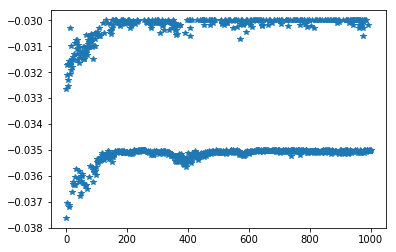

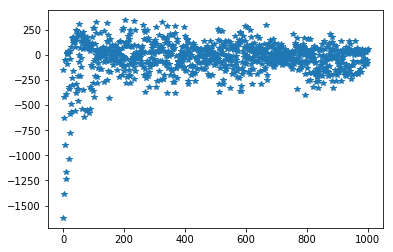

In [72]:
plt.plot(history['reward'], '*')
plt.show()
plt.plot(history['loss'], '*')
plt.show()

In [11]:
movement_action_seq

array([[3, 3, 3, 3],
       [2, 4, 3, 3],
       [3, 2, 0, 3],
       [0, 0, 3, 3],
       [3, 0, 2, 3],
       [2, 2, 3, 3],
       [0, 0, 3, 3],
       [4, 0, 2, 4],
       [2, 4, 0, 3],
       [3, 3, 2, 3]])